In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/ADMM_Code/bm3d_demos

/content/drive/MyDrive/ADMM_Code/bm3d_demos


In [ ]:
pip install bm3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.4 MB 4.7 MB/s 


Difference is: 
tensor(5.5638e-08) 

1 - cost: tensor(361.0294) crit: tensor(7.3618)
51 - cost: tensor(1586.3760) crit: tensor(0.2331)
101 - cost: tensor(1592.0372) crit: tensor(0.2004)
151 - cost: tensor(1591.7257) crit: tensor(0.2005)
201 - cost: tensor(1591.7902) crit: tensor(0.2012)
251 - cost: tensor(1591.7603) crit: tensor(0.2010)
301 - cost: tensor(1591.6136) crit: tensor(0.2029)
351 - cost: tensor(1591.8112) crit: tensor(0.2017)
401 - cost: tensor(1591.6283) crit: tensor(0.2010)
451 - cost: tensor(1591.8457) crit: tensor(0.2013)
501 - cost: tensor(1591.6942) crit: tensor(0.2006)
551 - cost: tensor(1591.6605) crit: tensor(0.2023)
601 - cost: tensor(1591.7372) crit: tensor(0.2013)
651 - cost: tensor(1591.5468) crit: tensor(0.2018)
701 - cost: tensor(1591.9729) crit: tensor(0.2003)
751 - cost: tensor(1591.4886) crit: tensor(0.2005)
801 - cost: tensor(1591.7610) crit: tensor(0.2019)
851 - cost: tensor(1591.7451) crit: tensor(0.2012)
901 - cost: tensor(1591.6006) crit: tensor(0.2031

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:586: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


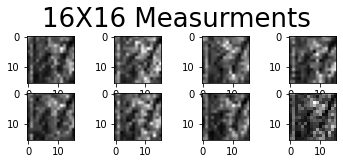

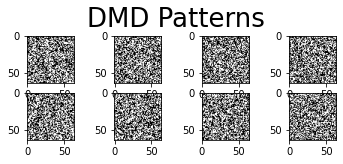

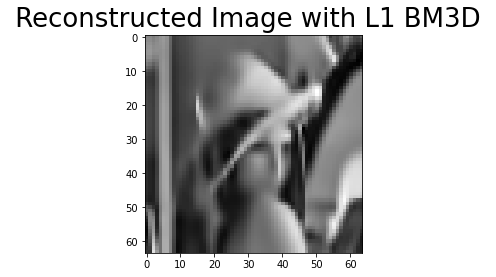

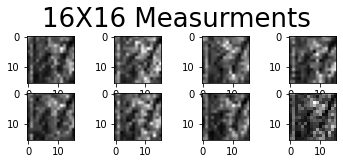

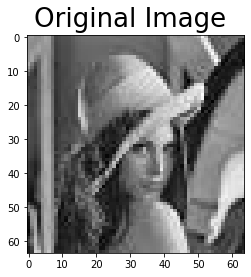

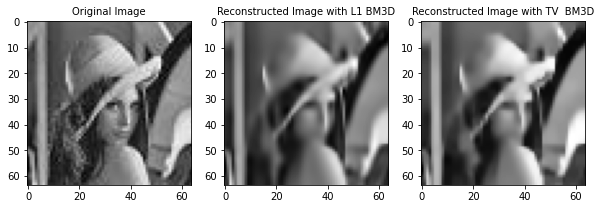

In [ ]:


# -*- coding: utf-8 -*-

#conda was installed locally thus, used to speed up the process



from skimage import io
from skimage.transform import downscale_local_mean
import torch 
import numpy as np
from matplotlib import pyplot as plt 
import cv2


from skimage import io
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from bm3d import bm3d, BM3DProfile
from experiment_funcs import get_experiment_noise, get_psnr, get_cropped_psnr
from math import *
import math


%matplotlib inline

plt.close('all')

def BM3D(x,noise_var):

    
    

    y_est = bm3d(x, sqrt(noise_var));


    # Ignore values outside range for display (or plt gives an error for multichannel input)
    denoied_image = np.minimum(np.maximum(y_est, 0), 1)
    #z_rang = np.minimum(np.maximum(noisy_signal, 0), 1)
    
    return denoied_image



def softT(x, tau):
    getSgn = torch.abs(x) - tau
    getSgn = getSgn * (torch.sign(getSgn) > 0)
#    return torch.sign(x) * getSgn
    return getSgn
def proj2T(s, y, epsilon):
    nrmVal = torch.norm(s - y)
    if (nrmVal > epsilon):
        return y + (epsilon / nrmVal) * (s - y)
    else:
        return s

def Q1(x):
    return x - x.roll(1,0)
def Q2(x):
    return x - x.roll(1,1)
def softTV(x, tau, numIter):
    if (tau == 0):
        return x
    n1, n2 = x.shape
    pn2 = pn1 = torch.zeros_like(x)
    for ii in range(numIter):
        myQst = (pn1.roll(-1,0) - pn1 + pn2.roll(-1,1) - pn2)
#        myQst = Qstar(pn1, pn2)
        vn1 = pn1 + 0.25 * Q1(myQst - x/tau)
        vn2 = pn2 + 0.25 * Q2(myQst - x/tau)
        d1 = vn1.abs()
        d2 = vn2.abs()
        pn1 = vn1 / (d1 * (d1 > 1) + (d1 <= 1))
        pn2 = vn2 / (d2 * (d2 > 1) + (d2 <= 1))
    return x - tau * (pn1.roll(-1,0) - pn1 + pn2.roll(-1,1) - pn2)

#--------------------------------------------------

def ADMMreconL1(AtC, MtC, datatC, mu, MaxIter, n1, n2, nData, epsilon, verboseIn):
    # initialize vectors
    x_conv = AtC.T @ datatC
    z0 = torch.zeros_like(x_conv, )
    d0 = torch.zeros_like(z0, )
    z2 = d2 = torch.zeros_like(datatC)

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    start.record()

    for ii in range(MaxIter):
        r = z0 + d0 + AtC.T @ (z2 + d2)
        x = MtC @ r
        Ax = AtC @ x
        z0 = torch.from_numpy(bm3d((x-d0).reshape(n1,n2),1/mu).reshape(n1*n2)).float()
        z2 = proj2T(Ax - d2, datatC, epsilon)

        d0 = d0 - x + z0
        d2 = d2 - Ax + z2
        if ii % verboseIn == 1:
            print(str(ii) + ' - cost: ' + str(torch.norm(x, p=1).detach()) + ' crit: ' + str(torch.norm(Ax - datatC).detach()) )
    torch.cuda.synchronize()
    end.record()
    print(str(ii) + ' - cost: ' + str(torch.norm(x, p=1).detach()) + ' crit: ' + str(torch.norm(Ax - datatC).detach()) )
#    print(start.elapsed_time(end))
    return x

#--------------------------------------------------

def ADMMrecon(AtC, MtC, datatC, mu, alpha_tv, MaxIter, n1, n2, nData, epsilon, verboseIn):
    # initialize vectors
   
    x_conv = AtC.T @ datatC
    z1 = z0 = torch.zeros_like(x_conv, )
    d1 = d0 = torch.zeros_like(z0, )
    z2 = d2 = torch.zeros_like(datatC)


    for ii in range(MaxIter):
        r = z1 + d1 + z0 + d0 + AtC.T @ (z2 + d2)
        x = MtC @ r
        Ax = AtC @ x
        z0 = torch.from_numpy(bm3d((x-d0).reshape(n1,n2),(1-alpha_tv)/mu).reshape(n1*n2)).float()   #z0 = softT(x - d0, (1-alpha_tv)/mu)     BM3D(my_image,noisy_signal,(1-alpha_tv)/mu).reshape(n1*n2)    torch.rand(4096,)
        z1 = softTV((x - d1).reshape(n1, n2), alpha_tv/mu, 7).reshape(n1*n2)
        z2 = proj2T(Ax - d2, datatC, epsilon)

        d0 = d0 - x + z0
        d1 = d1 - x + z1
        d2 = d2 - Ax + z2
        if ii % verboseIn == 1:
            print(str(ii) + ' - cost: ' + str(torch.norm(x, p=1).detach()) + ' crit: ' + str(torch.norm(Ax - datatC).detach()) )
    print(str(ii) + ' - cost: ' + str(torch.norm(x, p=1).detach()) + ' crit: ' + str(torch.norm(Ax - datatC).detach()) )
#    print(start.elapsed_time(end))
    return x
#--------------------------------------------------------------------------------------------------------------------------------------------
def ADMMreconTV(AtC, MtC, datatC, mu, MaxIter, n1, n2, nData, epsilon, verboseIn):
    # initialize vectors
    x_conv = AtC.T @ datatC
    z0 = torch.zeros_like(x_conv, )
    d0 = torch.zeros_like(z0, )
    z2 = d2 = torch.zeros_like(datatC)

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    start.record()

    for ii in range(MaxIter):
        r = z0 + d0 + AtC.T @ (z2 + d2)
        x = MtC @ r
        Ax = AtC @ x
        z0 = (softTV((x-d0).reshape(n1,n2),1/mu,7).reshape(n1*n2))
        z2 = proj2T(Ax - d2, datatC, epsilon)

        d0 = d0 - x + z0
        d2 = d2 - Ax + z2
        if ii % verboseIn == 1:
            print(str(ii) + ' - cost: ' + str(torch.norm(x, p=1).detach()) + ' crit: ' + str(torch.norm(Ax - datatC).detach()) )
    torch.cuda.synchronize()
    end.record()
    print(str(ii) + ' - cost: ' + str(torch.norm(x, p=1).detach()) + ' crit: ' + str(torch.norm(Ax - datatC).detach()) )
#    print(start.elapsed_time(end))
    return x
#---------------------------------------------------------------------------------------------------------------------------------------------
def ADMMreconDnCNNN(AtC, MtC, datatC, mu, MaxIter, n1, n2, nData, epsilon, verboseIn):
    # initialize vectors
    x_conv = AtC.T @ datatC
    z0 = torch.zeros_like(x_conv, )
    d0 = torch.zeros_like(z0, )
    z2 = d2 = torch.zeros_like(datatC)

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    start.record()

    for ii in range(MaxIter):
        r = z0 + d0 + AtC.T @ (z2 + d2)
        x = MtC @ r
        Ax = AtC @ x
        z0 = (BF_DnCNN((x-d0).cuda().reshape(1,1,n1,n2),1/mu,7).reshape(n1*n2)).cpu()
        z2 = proj2T(Ax - d2, datatC, epsilon)

        d0 = d0 - x + z0
        d2 = d2 - Ax + z2
        if ii % verboseIn == 1:
            print(str(ii) + ' - cost: ' + str(torch.norm(x, p=1).detach()) + ' crit: ' + str(torch.norm(Ax - datatC).detach()) )
    torch.cuda.synchronize()
    end.record()
    print(str(ii) + ' - cost: ' + str(torch.norm(x, p=1).detach()) + ' crit: ' + str(torch.norm(Ax - datatC).detach()) )
#    print(start.elapsed_time(end))
    return x
  #---------------------------------------------------------------------
my_image = io.imread(r"test_image.jpg",True) 

#noice added
noise = np.random.normal(0, .1, my_image.shape)
noisy_signal = my_image + noise
#-------------------------------------------------

# transform numpy into tensor
torch_my_image=torch.from_numpy(my_image)




coulmn_and_row=np.shape(my_image)

row=coulmn_and_row[0]


coulmn=coulmn_and_row[1]

sensor_dimension= 16

numSnapshots=8

#numSnapshots=((coulmn*row)//(sensor_dimension*sensor_dimension))




# generate 16 random DMD pattern
DMD_model=torch.randn((numSnapshots,coulmn,row)) > 0






# plot 16 different measurment values

plt.figure(2)
plt.suptitle('16X16 Measurments', fontsize=26)

for i in range(1,numSnapshots+1):
    Masks=DMD_model[i-1]*torch_my_image # elemnt wise multiplication of DMD model and object
    downscaled_image= downscale_local_mean(Masks, (int(row/sensor_dimension),int(coulmn/sensor_dimension))) # downscale the image into 16*16 using sckiimage library
    # plot in the same figure
    plt.subplot(int(row/sensor_dimension),int(coulmn/sensor_dimension),i) 
    plt.imshow(downscaled_image,cmap=plt.cm.gray)



# plot the 16 DMD pattterns
plt.figure(1)
plt.suptitle('DMD Patterns', fontsize=26)

for i in range(1,numSnapshots+1):

    plt.subplot(int(row/sensor_dimension),int(coulmn/sensor_dimension),i)
    plt.imshow(DMD_model[i-1],cmap=plt.cm.binary)

# plot the downscaled image to show difference between algorithms
plt.figure(5)
plt.suptitle('Downscale_by_function', fontsize=26)
plt.imshow(downscaled_image,cmap=plt.cm.binary)


 
def myFnc(x, DMD_model): 
    Measurements=torch.zeros((sensor_dimension*sensor_dimension) * numSnapshots,)
    for i in range(numSnapshots):
        Masks=DMD_model[i]*x # elemnt wise multiplication of DMD model and object
        downscaled_image= torch.from_numpy(downscale_local_mean(Masks, (int(row/sensor_dimension),int(coulmn/sensor_dimension)))) # downscale the image into 16*16 using sckiimage library
        floatted_downscaled_image=downscaled_image.reshape((sensor_dimension*sensor_dimension),)
        startInd = i * (sensor_dimension*sensor_dimension)
        endInd = startInd + (sensor_dimension*sensor_dimension)
        Measurements[startInd:endInd] = floatted_downscaled_image
    return Measurements
 
plt.figure(3)
plt.suptitle('16X16 Measurments', fontsize=26)
 
y = myFnc(torch_my_image, DMD_model)
 
measOut = y.reshape(numSnapshots, sensor_dimension, sensor_dimension)
for i in range(numSnapshots):
    plt.subplot(int(row/sensor_dimension),int(coulmn/sensor_dimension),i+1)
    plt.imshow(measOut[i,:,:],cmap=plt.cm.gray)
 
forwardMtx = torch.zeros(numSnapshots *sensor_dimension * sensor_dimension , coulmn , row, dtype=torch.float) 
 
for xPos in range(coulmn):
    for yPos in range(row):
        inImage = torch.zeros(coulmn, row, dtype=torch.float)
        inImage[xPos, yPos] = 1
        y = myFnc(inImage, DMD_model)
        forwardMtx[:, xPos, yPos] = y
 
forwardMtx = forwardMtx.reshape(-1, coulmn*row)
sampleDataViaFnc = myFnc(torch_my_image, DMD_model)
sampleDataViaMtx = forwardMtx @ torch_my_image.float().reshape(-1)
 
print("Difference is: ")
print(torch.norm(sampleDataViaFnc - sampleDataViaMtx) / torch.norm(sampleDataViaFnc),"\n")



#least square algorithm---------------------------- 
# lsqrRecon = (torch.pinverse(forwardMtx) @ sampleDataViaFnc).reshape(64, 64).detach().numpy()
 
# lsqrRecon = torch.lstsq(sampleDataViaFnc, forwardMtx).solution.reshape(coulmn, row).detach().numpy()   
 
# lsqrRecon[lsqrRecon>1] = 1
# lsqrRecon[lsqrRecon<0] = 0

#-------------------------------------------------- 



# ADMM reconstruciton alghoritms ----------------------------------------------

alpha_tv = 0.2# bu parametre değitşirilip sonuca etkisi değerlendirilebilir.
mu = 30# bu parametre değitşirilip sonuca etkisi değerlendirilebilir. 1000000 => bayaa kötü sonuç veriyo ama en azından net 100000 bu da çok iyi deil (15000 de fena değil)
epsilon = 0.2 # bu parametre değitşirilip sonuca etkisi değerlendirilebilir.


n1 = 64
n2 = 64
nData = sampleDataViaFnc.shape[0]
MaxIter = 1000
verboseIn = 50



MtC = torch.inverse( 2 * torch.eye(n1*n2) + forwardMtx.T @ forwardMtx )

MtC_L1 = torch.inverse( 1* torch.eye(n1*n2) + forwardMtx.T @ forwardMtx )

a=ADMMreconL1(forwardMtx, MtC_L1, sampleDataViaFnc, mu, MaxIter, n1, n2, nData, epsilon, verboseIn)

b=ADMMrecon(forwardMtx, MtC, sampleDataViaFnc, mu,alpha_tv, MaxIter, n1, n2, nData, epsilon, verboseIn)





#c=ADMMreconTV(forwardMtx, MtC_L1, sampleDataViaFnc, mu, MaxIter, n1, n2, nData, epsilon, verboseIn)

recons=a.resize(row,coulmn)  #row=64, coulmn=64  aim was to make code more generic the current image dimensions are 64x64

recons_2=b.resize(row,coulmn) 


loss=torch.nn.MSELoss()
MSE=loss(recons,torch_my_image)
pSNR=10*math.log10(1/MSE)
print("pSNR: ", pSNR, "dB ######################################################################")

#recons_3=c.resize(row,coulmn) 

#-------------------------------------------------------------------------------------

 
plt.figure(5)
plt.suptitle(' Reconstructed Image with L1 BM3D ', fontsize=26)
plt.imshow(recons,cmap=plt.cm.gray)

# # #this part is for gentaraing Reconstructed image with cv2.imshow
# imS = cv2.resize(recons.numpy(), (960, 960))   
# cv2.imshow('Reconstructed Image',imS) 
 
plt.figure(4)
plt.suptitle('Original Image', fontsize=26)
plt.imshow(my_image,cmap=plt.cm.gray)

plt.figure(figsize=(10, 10))

plt.subplot(1,3,1)

plt.title('Original Image',fontsize=10)
plt.imshow(my_image,cmap=plt.cm.gray)

plt.subplot(1,3,2)

plt.title('Reconstructed Image with L1 BM3D',fontsize=10)
plt.imshow(recons,cmap=plt.cm.gray)

plt.subplot(1,3,3)

plt.title('Reconstructed Image with TV  BM3D',fontsize=10)
plt.imshow(recons_2,cmap=plt.cm.gray)




# #this part is for gentaraing original image with cv2.imshow
# imS2 = cv2.resize(my_image, (960, 960))   
# cv2.imshow('Original Image',imS2) 


 




In [ ]:

from math import log10, sqrt
import cv2
import numpy as np

original = torch_my_image.numpy()
compressed = recons.numpy()


def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 1
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr
  
def main():

     value = PSNR(original, compressed)
     print(f"PSNR value is {value} dB")
       
if __name__ == "__main__":
    main()

PSNR value is 25.83892245812688 dB
